In [1]:
# import easyocr 
# reader = easyocr.Reader(['ko','en'])
# reader.readtext('Hangulssi_brandimg_1x1.jpg')

In [3]:
import matplotlib.font_manager as fm

sys_font=fm.findSystemFonts()

nanum_font = [f for f in sys_font if 'Nanum' in f]
nanum_font

['/usr/share/fonts/NanumFont/NanumBrush.ttf',
 '/usr/share/fonts/NanumFont/NanumGothic.ttf',
 '/usr/share/fonts/NanumFont/NanumGothicExtraBold.ttf',
 '/usr/share/fonts/NanumFont/NanumPen.ttf',
 '/usr/share/fonts/NanumFont/NanumMyeongjoBold.ttf',
 '/usr/share/fonts/NanumFont/NanumGothicBold.ttf',
 '/usr/share/fonts/NanumFont/NanumMyeongjo.ttf',
 '/usr/share/fonts/NanumFont/NanumMyeongjoExtraBold.ttf']

In [4]:
from matplotlib import pyplot as plt
from imutils.perspective import four_point_transform
from imutils.contours import sort_contours
import imutils
from easyocr import Reader
import cv2
import requests
import numpy as np
from PIL import ImageFont, ImageDraw, Image

In [5]:
def plt_imshow(title='image', img=None, figsize=(8 ,5)):
    plt.figure(figsize=figsize)

    if type(img) == list:
        if type(title) == list:
            titles = title
        else:
            titles = []

            for i in range(len(img)):
                titles.append(title)

        for i in range(len(img)):
            if len(img[i].shape) <= 2:
                rgbImg = cv2.cvtColor(img[i], cv2.COLOR_GRAY2RGB)
            else:
                rgbImg = cv2.cvtColor(img[i], cv2.COLOR_BGR2RGB)

            plt.subplot(1, len(img), i + 1), plt.imshow(rgbImg)
            plt.title(titles[i])
            plt.xticks([]), plt.yticks([])

        plt.show()
    else:
        if len(img.shape) < 3:
            rgbImg = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
        else:
            rgbImg = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        plt.imshow(rgbImg)
        plt.title(title)
        plt.xticks([]), plt.yticks([])
        plt.show()


def make_scan_image(image, width, ksize=(5,5), min_threshold=75, max_threshold=200):
  image_list_title = []
  image_list = []

  image = imutils.resize(image, width=width)
  ratio = org_image.shape[1] / float(image.shape[1])

  # 이미지를 grayscale로 변환하고 blur를 적용
  # 모서리를 찾기위한 이미지 연산
  gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
  blurred = cv2.GaussianBlur(gray, ksize, 0)
  edged = cv2.Canny(blurred, min_threshold, max_threshold)

  image_list_title = ['gray', 'blurred', 'edged']
  image_list = [gray, blurred, edged]

  # contours를 찾아 크기순으로 정렬
  cnts = cv2.findContours(edged.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
  cnts = imutils.grab_contours(cnts)
  cnts = sorted(cnts, key=cv2.contourArea, reverse=True)

  findCnt = None

  # 정렬된 contours를 반복문으로 수행하며 4개의 꼭지점을 갖는 도형을 검출
  for c in cnts:
    peri = cv2.arcLength(c, True)
    approx = cv2.approxPolyDP(c, 0.02 * peri, True)

    # contours가 크기순으로 정렬되어 있기때문에 제일 첫번째 사각형을 영역으로 판단하고 break
    if len(approx) == 4:
      findCnt = approx
      break


  # 만약 추출한 윤곽이 없을 경우 오류
  if findCnt is None:
    raise Exception(("Could not find outline."))


  output = image.copy()
  cv2.drawContours(output, [findCnt], -1, (0, 255, 0), 2)
  
  image_list_title.append("Outline")
  image_list.append(output)

  # 원본 이미지에 찾은 윤곽을 기준으로 이미지를 보정
  transform_image = four_point_transform(org_image, findCnt.reshape(4, 2) * ratio)

  plt_imshow(image_list_title, image_list)
  plt_imshow("Transform", transform_image)

  return transform_image


def putText(cv_img, text, x, y, color=(0, 0, 0), font_size=22):
  # Colab이 아닌 Local에서 수행 시에는 gulim.ttc 를 사용하면 됩니다.
  # font = ImageFont.truetype("fonts/gulim.ttc", font_size)
  font = ImageFont.truetype('/usr/share/fonts/truetype/nanum/NanumGothicBold.ttf', font_size)
  img = Image.fromarray(cv_img)
   
  draw = ImageDraw.Draw(img)
  draw.text((x, y), text, font=font, fill=color)

  cv_img = np.array(img)
  
  return cv_img

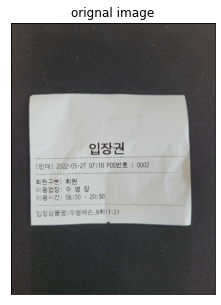

In [6]:
# url = 'https://user-images.githubusercontent.com/69428232/148511583-651cbe19-29ba-4b60-97b5-22c2829d56d9.jpg'

# image_nparray = np.asarray(bytearray(requests.get(url).content), dtype=np.uint8)
# org_image = cv2.imdecode(image_nparray, cv2.IMREAD_COLOR) 

org_image = cv2.imread('/home/yd/workspace/OCR/testImg2.jpg')

plt_imshow("orignal image", org_image)

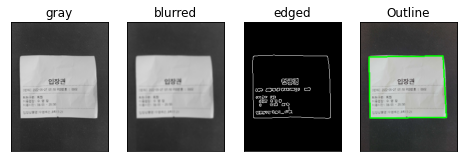

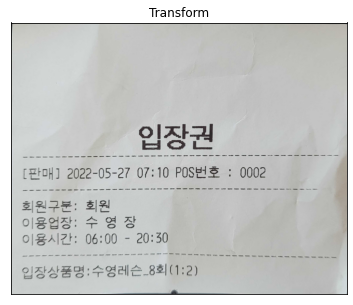

In [7]:
ID_card_image = make_scan_image(org_image, width=200, ksize=(5, 5), min_threshold=20, max_threshold=100)

In [8]:
langs = ['ko', 'en']

print("[INFO] OCR'ing input image...")
reader = Reader(lang_list=langs, gpu=True)
results = reader.readtext(ID_card_image)

/home/yd/anaconda3/envs/OCR/lib/python3.9/site-packages/torch/cuda/__init__.py:82: UserWarning: CUDA initialization: Unexpected error from cudaGetDeviceCount(). Did you run some cuda functions before calling NumCudaDevices() that might have already set an error? Error 804: forward compatibility was attempted on non supported HW (Triggered internally at  ../c10/cuda/CUDAFunctions.cpp:112.)
  return torch._C._cuda_getDeviceCount() > 0
CUDA not available - defaulting to CPU. Note: This module is much faster with a GPU.


[INFO] OCR'ing input image...


In [9]:
results

[([[862, 695], [1439, 695], [1439, 929], [862, 929]],
  '입장권',
  0.9999942874844068),
 ([[67, 1006], [847, 1006], [847, 1123], [67, 1123]],
  '[판매] 2022-05-27',
  0.8694695159188337),
 ([[872, 1001], [1475, 1001], [1475, 1111], [872, 1111]],
  '07: 10 POS번호',
  0.4393381351977859),
 ([[1513, 1033], [1551, 1033], [1551, 1089], [1513, 1089]],
  ';',
  0.582159285138605),
 ([[1594, 1002], [1800, 1002], [1800, 1106], [1594, 1106]],
  '00O2',
  0.3086511194705963),
 ([[69, 1239], [479, 1239], [479, 1353], [69, 1353]],
  '회원구분:',
  0.9991522432239421),
 ([[515, 1233], [705, 1233], [705, 1347], [515, 1347]],
  '회원',
  0.9999039908290579),
 ([[69, 1355], [481, 1355], [481, 1467], [69, 1467]],
  '이용업장:',
  0.9997078451200192),
 ([[514, 1348], [889, 1348], [889, 1463], [514, 1463]],
  '수 영 장',
  0.8893304119235872),
 ([[66, 1463], [485, 1463], [485, 1587], [66, 1587]],
  '이용시간:',
  0.999106336859265),
 ([[512, 1472], [758, 1472], [758, 1570], [512, 1570]],
  '06:OJO',
  0.1827414193203176),
 ([[

In [10]:
simple_results = reader.readtext(ID_card_image, detail = 0)
simple_results

['입장권',
 '[판매] 2022-05-27',
 '07: 10 POS번호',
 ';',
 '00O2',
 '회원구분:',
 '회원',
 '이용업장:',
 '수 영 장',
 '이용시간:',
 '06:OJO',
 '20:30',
 '입장상품명: 수영레손_8회 ( 1:2)']

In [11]:
# loop over the results
for (bbox, text, prob) in results:
  print("[INFO] {:.4f}: {}".format(prob, text))
  
  (tl, tr, br, bl) = bbox
  tl = (int(tl[0]), int(tl[1]))
  tr = (int(tr[0]), int(tr[1]))
  br = (int(br[0]), int(br[1]))
  bl = (int(bl[0]), int(bl[1]))

	# 추출한 영역에 사각형을 그리고 인식한 글자를 표기합니다.
  cv2.rectangle(ID_card_image, tl, br, (0, 255, 0), 2)
  business_card_image = putText(ID_card_image, text, tl[0], tl[1] - 60, (0, 255, 0), 50)
	# cv2.putText(business_card_image, text, (tl[0], tl[1] - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.8, (0, 255, 0), 2)

[INFO] 1.0000: 입장권
[INFO] 0.8695: [판매] 2022-05-27
[INFO] 0.4393: 07: 10 POS번호
[INFO] 0.5822: ;
[INFO] 0.3087: 00O2
[INFO] 0.9992: 회원구분:
[INFO] 0.9999: 회원
[INFO] 0.9997: 이용업장:
[INFO] 0.8893: 수 영 장
[INFO] 0.9991: 이용시간:
[INFO] 0.1827: 06:OJO
[INFO] 0.9990: 20:30
[INFO] 0.4749: 입장상품명: 수영레손_8회 ( 1:2)


In [12]:
# loop over the results
for (bbox, text, prob) in results:
  print("[INFO] {:.4f}: {}".format(prob, text))
  
  (tl, tr, br, bl) = bbox
  tl = (int(tl[0]), int(tl[1]))
  tr = (int(tr[0]), int(tr[1]))
  br = (int(br[0]), int(br[1]))
  bl = (int(bl[0]), int(bl[1]))

	# 추출한 영역에 사각형을 그리고 인식한 글자를 표기합니다.
  cv2.rectangle(ID_card_image, tl, br, (0, 255, 0), 2)
  ID_card_image = putText(ID_card_image, text, tl[0], tl[1] - 60, (0, 255, 0), 50)
	# cv2.putText(business_card_image, text, (tl[0], tl[1] - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.8, (0, 255, 0), 2)

[INFO] 1.0000: 입장권
[INFO] 0.8695: [판매] 2022-05-27
[INFO] 0.4393: 07: 10 POS번호
[INFO] 0.5822: ;
[INFO] 0.3087: 00O2
[INFO] 0.9992: 회원구분:
[INFO] 0.9999: 회원
[INFO] 0.9997: 이용업장:
[INFO] 0.8893: 수 영 장
[INFO] 0.9991: 이용시간:
[INFO] 0.1827: 06:OJO
[INFO] 0.9990: 20:30
[INFO] 0.4749: 입장상품명: 수영레손_8회 ( 1:2)


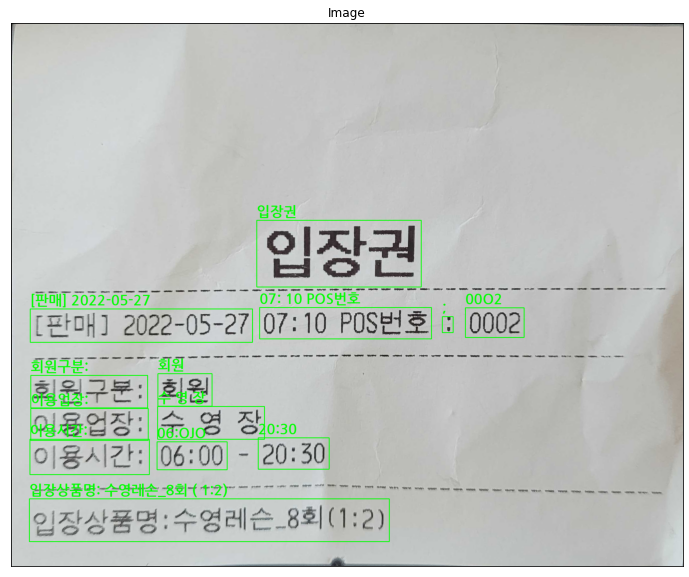

In [13]:
# show the output image
plt_imshow("Image", ID_card_image, figsize=(16,10))
